In [1]:
! pip install -q mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.6 MB/s eta 0:00:00


##Import libraries

In [2]:
import os
from pathlib import Path
import pandas as pd
import sklearn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    r2_score,
    mean_absolute_percentage_error
)

### Defin indexes





In [3]:
def compute_rsi(prices, period=14):
    """
    Compute the Relative Strength Index (RSI) for a series of prices.
    Returns a 1D numpy array of RSI values. The first (period-1) values will be NaN.
    """
    prices = np.array(prices)
    deltas = np.diff(prices)
    seed = deltas[:period]
    up = seed[seed >= 0].sum() / period
    down = -seed[seed < 0].sum() / period
    rs = up / down if down != 0 else 0
    rsi = np.zeros_like(prices)
    rsi[:period] = np.nan
    rsi[period - 1] = 100. - 100. / (1. + rs)
    for i in range(period, len(prices)):
        delta = deltas[i - 1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta
        up = (up * (period - 1) + upval) / period
        down = (down * (period - 1) + downval) / period
        rs = up / down if down != 0 else 0
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi

def compute_macd(prices, fast=12, slow=26, signal=9):
    """
    Compute the MACD (Moving Average Convergence Divergence) for a series of prices.
    Returns a tuple of three 1D numpy arrays: (macd, signal_line, histogram).
    """
    prices = pd.Series(np.array(prices).flatten())
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line
    return macd.values, signal_line.values, histogram.values

In [4]:
# Check if a CUDA-compatible GPU is available. If yes, use it; otherwise, fall back to the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

csv_file_path = '/content/bit_sen.csv'

# Extract base name without extension for naming
csv_base = Path(csv_file_path).stem

# Define paths for saving the best model and its metrics
model_history_dir = Path('model_history')
result_history_dir = Path('result_history')

os.makedirs(model_history_dir, exist_ok=True)
os.makedirs(result_history_dir, exist_ok=True)

best_model_filename = f"{csv_base}_best_model.pt"
best_model_path = model_history_dir / best_model_filename
metrics_path = result_history_dir / f"{csv_base}_metrics.txt"

forecast_history = 24  # Number of past time steps to use for input sequences.
forecast_horizon = 1  # Number of future time steps to predict (e.g., 0 means predicting the next step immediately).

batch_size = 64  # Number of samples in each mini-batch
max_iterations = 100
model_name = 'mLstm'

best_mse = float('inf')

###Preprocess

In [5]:
# Load Data
try:
  df_raw = pd.read_csv(csv_file_path)
  print("CSV file loaded successfully.")
except Exception as e:
  print(f"Error reading CSV file: {e}")

df_raw.head(10)

CSV file loaded successfully.


,positive,negetive,neutral,Date,Price,Open,High,Low,Vol.,Change %
0,0.116094,0.789252,0.094654,2015-01-01,313.9,317.5,317.5,312.9,0.93K,-0.99%
1,0.113846,0.795338,0.090816,2015-01-02,315.1,313.6,316.0,313.0,1.32K,0.40%
2,0.114822,0.795150,0.090027,2015-01-03,282.0,314.8,314.8,282.0,1.30K,-10.51%
3,0.114798,0.790363,0.094839,2015-01-04,258.8,282.0,288.9,258.8,2.38K,-8.23%
4,0.117028,0.790906,0.092066,2015-01-05,273.2,261.0,276.5,260.5,2.68K,5.57%
5,0.113413,0.791942,0.094645,2015-01-06,285.4,273.2,287.8,268.5,6.86K,4.46%
6,0.117202,0.788809,0.093989,2015-01-07,297.0,286.1,303.8,285.0,1.53K,4.07%
7,0.114490,0.784668,0.100843,2015-01-08,285.6,296.2,296.2,285.6,1.31K,-3.82%
8,0.111742,0.798039,0.090218,2015-01-09,292.8,285.4,295.6,283.0,1.26K,2.52%
9,0.113061,0.791843,0.095096,2015-01-10,275.0,292.4,292.4,271.0,1.11K,-6.08%


In [6]:
# Preprocess data
datetime_col = "Date"
freq = '1D'
columns = ['Price']
method = 'ffill'
value = 0


# Define a data preprocessing pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    # Step 1: Drop duplicate rows based on the datetime column
    ('drop_duplicates', sklearn.preprocessing.FunctionTransformer(lambda df: df.drop_duplicates(subset=datetime_col))),

    # Step 2: Fill missing values in the dataset
    ('fill_missing', sklearn.preprocessing.FunctionTransformer(
        lambda df: df.fillna(method=method).fillna(value=value)  # Fill missing values using a specified method and value
    ))
])

# Apply the pipeline to the raw data
df = preproc_pipe.fit_transform(df_raw)

# Convert the datetime column to a standard datetime format
df[datetime_col] = pd.to_datetime(df[datetime_col])

# Sort the data by the datetime column in ascending order
df = df.sort_values(by=datetime_col)



<ipython-input-6-9782ae18296c>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda df: df.fillna(method=method).fillna(value=value)  # Fill missing values using a specified method and value


In [7]:
# Define the proportions for test and validation sets
test_size = 0.05  # Fraction of the data to be used as the test set
valid_size = 0.05  # Fraction of the data to be used as the validation set

# Calculate the total number of samples in the dataset
total_size = len(df)  # The total number of rows in the DataFrame

# Calculate the number of samples for the test set
test_split = int(total_size * test_size)  # Convert the test size fraction to the actual count

# Calculate the number of samples for the validation set
valid_split = int(total_size * valid_size)  # Convert the validation size fraction to the actual count

# Calculate the end index of the training set (exclusive)
train_end = total_size - test_split - valid_split  # Determine where the training set ends

# Calculate the end index of the validation set (exclusive)
valid_end = total_size - test_split  # Determine where the validation set ends

# Split the data into training, validation, and test sets using indices
train_df = df.iloc[:train_end]  # Select rows for the training set
valid_df = df.iloc[train_end:valid_end]  # Select rows for the validation set
test_df = df.iloc[valid_end:]  # Select rows for the test set

# Print the sizes of each split for verification
print(f"Data split into train ({len(train_df)}), validation ({len(valid_df)}), and test ({len(test_df)}) sets.")


Data split into train (1608), validation (89), and test (89) sets.


In [8]:
def concat(df):
  '''
    Returns numpy.ndarray: A concatenated array where:
    First columns contain sentiment values (in order: positive, negative, neutral)
    Remaining columns contain scaled price values (order determined by scale_columns)
  '''
  sent = df[['positive', 'negetive', 'neutral']].to_numpy()
  price = scaler.transform(df[scale_columns])

  return np.concat([sent,price], axis=1)

In [9]:
# Define the columns to be scaled
scale_columns = ['Price']  # Specify the column(s) to scale, in this case 'Price'

# Initialize the MinMaxScaler with a feature range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler using the training data
scaler.fit(train_df[scale_columns])  # Calculate the min and max values from the training set for scaling

# Transform the training data using the fitted scaler
train_scaled = scaler.transform(train_df[scale_columns])  # Scale the 'Price' column in the training set

# Transform the validation data using the same scaler
valid_scaled = scaler.transform(valid_df[scale_columns])  # Apply the same scaling to the validation set

# Transform the test data using the same scaler
test_scaled = scaler.transform(test_df[scale_columns])  # Apply the same scaling to the test set

# Print a message indicating that the scaling is complete
print("Data scaling completed.")


Data scaling completed.


In [10]:

# Function to create input-output sequences for training/testing
def create_sequences(data, seq_length, horizon):
    """
    Generate sequences of input features (X) and corresponding target values (y).

    Args:
        data: The scaled dataset to create sequences from.
        seq_length: Number of past time steps to use as input.
        horizon: Number of future time steps to predict.


    Returns:
        X (Tensor): Tensor of input sequences.
        y (Tensor): Tensor of target values corresponding to the sequences.
    """
    X, y = [], []  # Initialize empty lists for input (X) and output (y)

    # Iterate over the dataset to create sequences
    for i in range(len(data) - seq_length - horizon + 1):  # Ensure valid indices for sequences
        X.append(data[i:(i + seq_length)].flatten().reshape((-1,1)))  # Extract 'seq_length' past time steps
        y.append(data[[i + seq_length + horizon - 1],[-1]])  # Extract the target value at the specified horizon
    return torch.Tensor(X), torch.Tensor(y)  # Convert lists to PyTorch tensors for use in models

# Create input and output sequences for the training set
trainX, trainY = create_sequences(train_scaled, forecast_history, forecast_horizon)

# Create input and output sequences for the validation set
validX, validY = create_sequences(valid_scaled, forecast_history, forecast_horizon)

# Create input and output sequences for the test set
testX, testY = create_sequences(test_scaled, forecast_history, forecast_horizon)

print('Data sequence is created.')

Data sequence is created.


<ipython-input-10-4e7f8ca63965>:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.Tensor(X), torch.Tensor(y)  # Convert lists to PyTorch tensors for use in models


In [11]:
# Create datasets for training, validation, and testing
train_dataset = TensorDataset(trainX, trainY)  # Pair input sequences (trainX) with corresponding targets (trainY)
valid_dataset = TensorDataset(validX, validY)  # Pair validation inputs (validX) with targets (validY)
test_dataset = TensorDataset(testX, testY)  # Pair test inputs (testX) with targets (testY)

# Create data loaders for efficient batching during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Load training data with shuffling for randomized batches
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)  # Load validation data without shuffling for consistent order
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Load test data without shuffling for consistent order


###Define model

In [12]:
from xLSTM import mLSTM

In [13]:
# Define model parameters
input_size = 1
head_size = 32
num_layers = 3
num_heads = 2


# Create the mLSTM model
model = mLSTM(input_size, head_size, num_heads, num_layers=num_layers, batch_first=True).to(device)
# - `batch_first=True`: Input tensors should have shape (batch_size, sequence_length, input_size).
# - `.to(device)`: Move the model to the specified device (e.g., GPU or CPU).


# Define the loss function to measure the model's error
criterion = torch.nn.MSELoss()
# - `MSELoss`: Mean Squared Error loss is suitable for regression tasks, where the goal is to minimize the difference between predicted and actual values.


# Define the optimizer to update model parameters during training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# - Uses the Adam optimizer, which adapts the learning rate for each parameter.
# - `lr=0.001`: Sets the learning rate for the optimizer.


###Train

In [14]:
def log_print(*args, **kwargs):
    with open(metrics_path, 'a') as metrics_file:
        msg = ' '.join(map(str, args))
        print(msg)
        metrics_file.write(msg + '\n')

In [15]:
log_print(f"Model Name: {model_name}")
log_print(f"Sequence Length (Forecast History): {forecast_history}")
log_print(f"Forecast Horizon: {forecast_horizon}")
log_print(f"Training Started at: {pd.Timestamp.now()}")
for iteration in range(max_iterations):
            log_print(f"\nStarting training iteration {iteration + 1}/{max_iterations}")

            model.train()
            epoch_loss = 0
            for inputs, targets in tqdm(train_loader, desc=f"Training Iteration {iteration + 1}"):
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs, _ = model(inputs)
                outputs = outputs[:, -1, :]  # Take the last output
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_epoch_loss = epoch_loss / len(train_loader)
            log_print(f"Iteration {iteration + 1}: Average Training Loss: {avg_epoch_loss:.6f}")

            # Validate the model
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs, _ = model(inputs)
                    outputs = outputs[:, -1, :]
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(valid_loader)
            log_print(f"Iteration {iteration + 1}: Average Validation Loss: {avg_val_loss:.6f}")

            if avg_val_loss < best_mse:
                best_mse = avg_val_loss
                torch.save(model.state_dict(), best_model_path)
                log_print(f"New best model saved at '{best_model_path}' with Validation MSE {best_mse:.6f}")

Model Name: mLstm
Sequence Length (Forecast History): 24
Forecast Horizon: 1
Training Started at: 2025-05-20 13:51:22.967649

Starting training iteration 1/100


Training Iteration 1: 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]


Iteration 1: Average Training Loss: 0.017104
Iteration 1: Average Validation Loss: 0.021974
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.021974

Starting training iteration 2/100


Training Iteration 2: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Iteration 2: Average Training Loss: 0.001094
Iteration 2: Average Validation Loss: 0.009493
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.009493

Starting training iteration 3/100


Training Iteration 3: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Iteration 3: Average Training Loss: 0.000248
Iteration 3: Average Validation Loss: 0.008824
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.008824

Starting training iteration 4/100


Training Iteration 4: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Iteration 4: Average Training Loss: 0.000212
Iteration 4: Average Validation Loss: 0.008177
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.008177

Starting training iteration 5/100


Training Iteration 5: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


Iteration 5: Average Training Loss: 0.000221
Iteration 5: Average Validation Loss: 0.008276

Starting training iteration 6/100


Training Iteration 6: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Iteration 6: Average Training Loss: 0.000212
Iteration 6: Average Validation Loss: 0.007467
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.007467

Starting training iteration 7/100


Training Iteration 7: 100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Iteration 7: Average Training Loss: 0.000217
Iteration 7: Average Validation Loss: 0.007518

Starting training iteration 8/100


Training Iteration 8: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Iteration 8: Average Training Loss: 0.000215
Iteration 8: Average Validation Loss: 0.007081
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.007081

Starting training iteration 9/100


Training Iteration 9: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Iteration 9: Average Training Loss: 0.000213
Iteration 9: Average Validation Loss: 0.006486
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.006486

Starting training iteration 10/100


Training Iteration 10: 100%|██████████| 25/25 [00:10<00:00,  2.34it/s]


Iteration 10: Average Training Loss: 0.000229
Iteration 10: Average Validation Loss: 0.006592

Starting training iteration 11/100


Training Iteration 11: 100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Iteration 11: Average Training Loss: 0.000209
Iteration 11: Average Validation Loss: 0.006190
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.006190

Starting training iteration 12/100


Training Iteration 12: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Iteration 12: Average Training Loss: 0.000214
Iteration 12: Average Validation Loss: 0.005840
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.005840

Starting training iteration 13/100


Training Iteration 13: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Iteration 13: Average Training Loss: 0.000216
Iteration 13: Average Validation Loss: 0.006129

Starting training iteration 14/100


Training Iteration 14: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


Iteration 14: Average Training Loss: 0.000207
Iteration 14: Average Validation Loss: 0.005140
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.005140

Starting training iteration 15/100


Training Iteration 15: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Iteration 15: Average Training Loss: 0.000222
Iteration 15: Average Validation Loss: 0.005413

Starting training iteration 16/100


Training Iteration 16: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Iteration 16: Average Training Loss: 0.000211
Iteration 16: Average Validation Loss: 0.005074
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.005074

Starting training iteration 17/100


Training Iteration 17: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Iteration 17: Average Training Loss: 0.000210
Iteration 17: Average Validation Loss: 0.004607
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.004607

Starting training iteration 18/100


Training Iteration 18: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Iteration 18: Average Training Loss: 0.000214
Iteration 18: Average Validation Loss: 0.004408
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.004408

Starting training iteration 19/100


Training Iteration 19: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Iteration 19: Average Training Loss: 0.000219
Iteration 19: Average Validation Loss: 0.004591

Starting training iteration 20/100


Training Iteration 20: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


Iteration 20: Average Training Loss: 0.000209
Iteration 20: Average Validation Loss: 0.003447
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.003447

Starting training iteration 21/100


Training Iteration 21: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Iteration 21: Average Training Loss: 0.000210
Iteration 21: Average Validation Loss: 0.003342
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.003342

Starting training iteration 22/100


Training Iteration 22: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Iteration 22: Average Training Loss: 0.000216
Iteration 22: Average Validation Loss: 0.003346

Starting training iteration 23/100


Training Iteration 23: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]


Iteration 23: Average Training Loss: 0.000215
Iteration 23: Average Validation Loss: 0.003212
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.003212

Starting training iteration 24/100


Training Iteration 24: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


Iteration 24: Average Training Loss: 0.000206
Iteration 24: Average Validation Loss: 0.002973
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.002973

Starting training iteration 25/100


Training Iteration 25: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Iteration 25: Average Training Loss: 0.000206
Iteration 25: Average Validation Loss: 0.002848
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.002848

Starting training iteration 26/100


Training Iteration 26: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Iteration 26: Average Training Loss: 0.000208
Iteration 26: Average Validation Loss: 0.002635
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.002635

Starting training iteration 27/100


Training Iteration 27: 100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Iteration 27: Average Training Loss: 0.000209
Iteration 27: Average Validation Loss: 0.002765

Starting training iteration 28/100


Training Iteration 28: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Iteration 28: Average Training Loss: 0.000207
Iteration 28: Average Validation Loss: 0.002123
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.002123

Starting training iteration 29/100


Training Iteration 29: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Iteration 29: Average Training Loss: 0.000207
Iteration 29: Average Validation Loss: 0.002180

Starting training iteration 30/100


Training Iteration 30: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Iteration 30: Average Training Loss: 0.000207
Iteration 30: Average Validation Loss: 0.002503

Starting training iteration 31/100


Training Iteration 31: 100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Iteration 31: Average Training Loss: 0.000210
Iteration 31: Average Validation Loss: 0.002125

Starting training iteration 32/100


Training Iteration 32: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


Iteration 32: Average Training Loss: 0.000208
Iteration 32: Average Validation Loss: 0.002070
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.002070

Starting training iteration 33/100


Training Iteration 33: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Iteration 33: Average Training Loss: 0.000207
Iteration 33: Average Validation Loss: 0.002315

Starting training iteration 34/100


Training Iteration 34: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Iteration 34: Average Training Loss: 0.000207
Iteration 34: Average Validation Loss: 0.002052
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.002052

Starting training iteration 35/100


Training Iteration 35: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Iteration 35: Average Training Loss: 0.000210
Iteration 35: Average Validation Loss: 0.002177

Starting training iteration 36/100


Training Iteration 36: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


Iteration 36: Average Training Loss: 0.000212
Iteration 36: Average Validation Loss: 0.001883
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.001883

Starting training iteration 37/100


Training Iteration 37: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Iteration 37: Average Training Loss: 0.000213
Iteration 37: Average Validation Loss: 0.001735
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.001735

Starting training iteration 38/100


Training Iteration 38: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Iteration 38: Average Training Loss: 0.000206
Iteration 38: Average Validation Loss: 0.001901

Starting training iteration 39/100


Training Iteration 39: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Iteration 39: Average Training Loss: 0.000213
Iteration 39: Average Validation Loss: 0.001963

Starting training iteration 40/100


Training Iteration 40: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


Iteration 40: Average Training Loss: 0.000224
Iteration 40: Average Validation Loss: 0.001344
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.001344

Starting training iteration 41/100


Training Iteration 41: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Iteration 41: Average Training Loss: 0.000221
Iteration 41: Average Validation Loss: 0.001878

Starting training iteration 42/100


Training Iteration 42: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Iteration 42: Average Training Loss: 0.000209
Iteration 42: Average Validation Loss: 0.001921

Starting training iteration 43/100


Training Iteration 43: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Iteration 43: Average Training Loss: 0.000212
Iteration 43: Average Validation Loss: 0.001959

Starting training iteration 44/100


Training Iteration 44: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


Iteration 44: Average Training Loss: 0.000209
Iteration 44: Average Validation Loss: 0.002157

Starting training iteration 45/100


Training Iteration 45: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Iteration 45: Average Training Loss: 0.000213
Iteration 45: Average Validation Loss: 0.002350

Starting training iteration 46/100


Training Iteration 46: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Iteration 46: Average Training Loss: 0.000213
Iteration 46: Average Validation Loss: 0.001913

Starting training iteration 47/100


Training Iteration 47: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Iteration 47: Average Training Loss: 0.000211
Iteration 47: Average Validation Loss: 0.002117

Starting training iteration 48/100


Training Iteration 48: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Iteration 48: Average Training Loss: 0.000208
Iteration 48: Average Validation Loss: 0.002140

Starting training iteration 49/100


Training Iteration 49: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Iteration 49: Average Training Loss: 0.000209
Iteration 49: Average Validation Loss: 0.001723

Starting training iteration 50/100


Training Iteration 50: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Iteration 50: Average Training Loss: 0.000207
Iteration 50: Average Validation Loss: 0.001716

Starting training iteration 51/100


Training Iteration 51: 100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


Iteration 51: Average Training Loss: 0.000206
Iteration 51: Average Validation Loss: 0.001638

Starting training iteration 52/100


Training Iteration 52: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


Iteration 52: Average Training Loss: 0.000214
Iteration 52: Average Validation Loss: 0.001802

Starting training iteration 53/100


Training Iteration 53: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Iteration 53: Average Training Loss: 0.000215
Iteration 53: Average Validation Loss: 0.002121

Starting training iteration 54/100


Training Iteration 54: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Iteration 54: Average Training Loss: 0.000209
Iteration 54: Average Validation Loss: 0.001685

Starting training iteration 55/100


Training Iteration 55: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s]


Iteration 55: Average Training Loss: 0.000218
Iteration 55: Average Validation Loss: 0.001431

Starting training iteration 56/100


Training Iteration 56: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Iteration 56: Average Training Loss: 0.000226
Iteration 56: Average Validation Loss: 0.001751

Starting training iteration 57/100


Training Iteration 57: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Iteration 57: Average Training Loss: 0.000208
Iteration 57: Average Validation Loss: 0.001466

Starting training iteration 58/100


Training Iteration 58: 100%|██████████| 25/25 [00:09<00:00,  2.50it/s]


Iteration 58: Average Training Loss: 0.000211
Iteration 58: Average Validation Loss: 0.001540

Starting training iteration 59/100


Training Iteration 59: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


Iteration 59: Average Training Loss: 0.000206
Iteration 59: Average Validation Loss: 0.001978

Starting training iteration 60/100


Training Iteration 60: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


Iteration 60: Average Training Loss: 0.000209
Iteration 60: Average Validation Loss: 0.001608

Starting training iteration 61/100


Training Iteration 61: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Iteration 61: Average Training Loss: 0.000218
Iteration 61: Average Validation Loss: 0.001354

Starting training iteration 62/100


Training Iteration 62: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Iteration 62: Average Training Loss: 0.000219
Iteration 62: Average Validation Loss: 0.001471

Starting training iteration 63/100


Training Iteration 63: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Iteration 63: Average Training Loss: 0.000227
Iteration 63: Average Validation Loss: 0.001935

Starting training iteration 64/100


Training Iteration 64: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Iteration 64: Average Training Loss: 0.000233
Iteration 64: Average Validation Loss: 0.001453

Starting training iteration 65/100


Training Iteration 65: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


Iteration 65: Average Training Loss: 0.000218
Iteration 65: Average Validation Loss: 0.001248
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.001248

Starting training iteration 66/100


Training Iteration 66: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


Iteration 66: Average Training Loss: 0.000217
Iteration 66: Average Validation Loss: 0.001526

Starting training iteration 67/100


Training Iteration 67: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Iteration 67: Average Training Loss: 0.000209
Iteration 67: Average Validation Loss: 0.001155
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.001155

Starting training iteration 68/100


Training Iteration 68: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


Iteration 68: Average Training Loss: 0.000218
Iteration 68: Average Validation Loss: 0.001398

Starting training iteration 69/100


Training Iteration 69: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


Iteration 69: Average Training Loss: 0.000212
Iteration 69: Average Validation Loss: 0.001237

Starting training iteration 70/100


Training Iteration 70: 100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Iteration 70: Average Training Loss: 0.000212
Iteration 70: Average Validation Loss: 0.001017
New best model saved at 'model_history/bit_sen_best_model.pt' with Validation MSE 0.001017

Starting training iteration 71/100


Training Iteration 71: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Iteration 71: Average Training Loss: 0.000208
Iteration 71: Average Validation Loss: 0.001168

Starting training iteration 72/100


Training Iteration 72: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Iteration 72: Average Training Loss: 0.000222
Iteration 72: Average Validation Loss: 0.001395

Starting training iteration 73/100


Training Iteration 73: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Iteration 73: Average Training Loss: 0.000221
Iteration 73: Average Validation Loss: 0.001413

Starting training iteration 74/100


Training Iteration 74: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


Iteration 74: Average Training Loss: 0.000213
Iteration 74: Average Validation Loss: 0.001269

Starting training iteration 75/100


Training Iteration 75: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Iteration 75: Average Training Loss: 0.000209
Iteration 75: Average Validation Loss: 0.001095

Starting training iteration 76/100


Training Iteration 76: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Iteration 76: Average Training Loss: 0.000214
Iteration 76: Average Validation Loss: 0.001399

Starting training iteration 77/100


Training Iteration 77: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Iteration 77: Average Training Loss: 0.000204
Iteration 77: Average Validation Loss: 0.001816

Starting training iteration 78/100


Training Iteration 78: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Iteration 78: Average Training Loss: 0.000211
Iteration 78: Average Validation Loss: 0.001610

Starting training iteration 79/100


Training Iteration 79: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


Iteration 79: Average Training Loss: 0.000210
Iteration 79: Average Validation Loss: 0.001701

Starting training iteration 80/100


Training Iteration 80: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Iteration 80: Average Training Loss: 0.000215
Iteration 80: Average Validation Loss: 0.001197

Starting training iteration 81/100


Training Iteration 81: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]


Iteration 81: Average Training Loss: 0.000222
Iteration 81: Average Validation Loss: 0.001421

Starting training iteration 82/100


Training Iteration 82: 100%|██████████| 25/25 [00:10<00:00,  2.39it/s]


Iteration 82: Average Training Loss: 0.000217
Iteration 82: Average Validation Loss: 0.001726

Starting training iteration 83/100


Training Iteration 83: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Iteration 83: Average Training Loss: 0.000234
Iteration 83: Average Validation Loss: 0.002173

Starting training iteration 84/100


Training Iteration 84: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


Iteration 84: Average Training Loss: 0.000208
Iteration 84: Average Validation Loss: 0.002052

Starting training iteration 85/100


Training Iteration 85: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Iteration 85: Average Training Loss: 0.000210
Iteration 85: Average Validation Loss: 0.002166

Starting training iteration 86/100


Training Iteration 86: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Iteration 86: Average Training Loss: 0.000219
Iteration 86: Average Validation Loss: 0.001461

Starting training iteration 87/100


Training Iteration 87: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


Iteration 87: Average Training Loss: 0.000209
Iteration 87: Average Validation Loss: 0.001850

Starting training iteration 88/100


Training Iteration 88: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]


Iteration 88: Average Training Loss: 0.000216
Iteration 88: Average Validation Loss: 0.001927

Starting training iteration 89/100


Training Iteration 89: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


Iteration 89: Average Training Loss: 0.000220
Iteration 89: Average Validation Loss: 0.002264

Starting training iteration 90/100


Training Iteration 90: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Iteration 90: Average Training Loss: 0.000215
Iteration 90: Average Validation Loss: 0.002076

Starting training iteration 91/100


Training Iteration 91: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


Iteration 91: Average Training Loss: 0.000215
Iteration 91: Average Validation Loss: 0.001402

Starting training iteration 92/100


Training Iteration 92: 100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


Iteration 92: Average Training Loss: 0.000210
Iteration 92: Average Validation Loss: 0.001367

Starting training iteration 93/100


Training Iteration 93: 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


Iteration 93: Average Training Loss: 0.000217
Iteration 93: Average Validation Loss: 0.001244

Starting training iteration 94/100


Training Iteration 94: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


Iteration 94: Average Training Loss: 0.000217
Iteration 94: Average Validation Loss: 0.001572

Starting training iteration 95/100


Training Iteration 95: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


Iteration 95: Average Training Loss: 0.000237
Iteration 95: Average Validation Loss: 0.001701

Starting training iteration 96/100


Training Iteration 96: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Iteration 96: Average Training Loss: 0.000214
Iteration 96: Average Validation Loss: 0.001180

Starting training iteration 97/100


Training Iteration 97: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]


Iteration 97: Average Training Loss: 0.000226
Iteration 97: Average Validation Loss: 0.001047

Starting training iteration 98/100


Training Iteration 98: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


Iteration 98: Average Training Loss: 0.000211
Iteration 98: Average Validation Loss: 0.001950

Starting training iteration 99/100


Training Iteration 99: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


Iteration 99: Average Training Loss: 0.000246
Iteration 99: Average Validation Loss: 0.001229

Starting training iteration 100/100


Training Iteration 100: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]

Iteration 100: Average Training Loss: 0.000227
Iteration 100: Average Validation Loss: 0.001881


###Evalute

In [16]:
include_baseline  = True

In [17]:
# After training, evaluate on the test set
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint)

model.eval()

test_predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs, _ = model(inputs)
        outputs = outputs[:, -1, :]
        test_predictions.extend(outputs.cpu().numpy())
        actuals.extend(targets.cpu().numpy())

test_predictions = scaler.inverse_transform(np.array(test_predictions))
actuals = scaler.inverse_transform(np.array(actuals))

mse_val = mean_squared_error(actuals, test_predictions)
mae_val = mean_absolute_error(actuals, test_predictions)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(actuals, test_predictions)
mape_val = mean_absolute_percentage_error(actuals, test_predictions)

log_print("\nTest Regression Metrics:")
log_print(f"\nFinal Test MSE: {mse_val:.6f}")
log_print(f"Final Test MAE: {mae_val:.6f}")
log_print(f"  R2   : {r2_val:.6f}")
log_print(f"  MAPE : {mape_val:.6f}")

if include_baseline:
    baseline_predictions = []
    for i in range(len(testX)):
        baseline_predictions.append(testX[i][-1][-1].item())
    baseline_predictions = scaler.inverse_transform(np.array(baseline_predictions).reshape(-1, 1))
    baseline_mse = mean_squared_error(actuals, baseline_predictions)
    baseline_mae = mean_absolute_error(actuals, baseline_predictions)
    baseline_rmse = np.sqrt(baseline_mse)
    log_print("\nBaseline Metrics:")
    log_print(f"Baseline Test MSE: {baseline_mse:.6f}")
    log_print(f"Baseline Test MAE: {baseline_mae:.6f}")
    mse_diff = mse_val - baseline_mse
    mse_percentage = (mse_diff / baseline_mse) * 100
    if mse_percentage > 0:
        log_print(f"Model MSE is worse by {mse_percentage:.2f}% compared to the baseline.")
    else:
        log_print(f"Model MSE is better by {abs(mse_percentage):.2f}% compared to the baseline.")

log_print(f"\nTest Metrics saved at '{metrics_path}'")

# --- Additional RSI and MACD Metrics ---
if len(actuals) >= 14:
    rsi_actual = compute_rsi(actuals, period=14)
    rsi_pred = compute_rsi(test_predictions, period=14)
    valid_idx = ~np.isnan(rsi_actual)
    if valid_idx.sum() > 0:
        rsi_mae = mean_absolute_error(rsi_actual[valid_idx], rsi_pred[valid_idx])
        rsi_mse = mean_squared_error(rsi_actual[valid_idx], rsi_pred[valid_idx])
        log_print("\nRSI Metrics:")
        log_print(f"  RSI MAE: {rsi_mae:.4f}")
        log_print(f"  RSI MSE: {rsi_mse:.4f}")
if len(actuals) >= 26:
    def compute_macd_local(prices, fast=12, slow=26, signal=9):
        prices = pd.Series(np.array(prices).flatten())
        ema_fast = prices.ewm(span=fast, adjust=False).mean()
        ema_slow = prices.ewm(span=slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal_line = macd.ewm(span=signal, adjust=False).mean()
        histogram = macd - signal_line
        return macd.values, signal_line.values, histogram.values
    macd_actual, _, _ = compute_macd_local(actuals)
    macd_pred, _, _ = compute_macd_local(test_predictions)
    macd_mae = mean_absolute_error(macd_actual, macd_pred)
    log_print("\nMACD Metric:")
    log_print(f"  MACD MAE: {macd_mae:.4f}")


Test Regression Metrics:

Final Test MSE: 93228.929688
Final Test MAE: 201.346130
  R2   : 0.774367
  MAPE : 0.023707

Baseline Metrics:
Baseline Test MSE: 90309.161518
Baseline Test MAE: 195.009296
Model MSE is worse by 3.23% compared to the baseline.

Test Metrics saved at 'result_history/bit_sen_metrics.txt'

RSI Metrics:
  RSI MAE: 0.0000
  RSI MSE: 0.0000

MACD Metric:
  MACD MAE: 33.9430


<ipython-input-3-02e1026c30d2>:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if delta > 0:
<ipython-input-3-02e1026c30d2>:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  rs = up / down if down != 0 else 0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
try:
  results = pd.read_csv('/content/drive/MyDrive/bitcoin/results.csv')
except Exception as e:
  print(e)
  results = pd.DataFrame(columns=['model','MSE', 'MAE','R2_score','MAPE','time frame', 'type'])

results.loc[len(results)] = [model_name, mse_val, mae_val, r2_val, mape_val, '2015_2019' , 'hs']
results.to_csv('/content/drive/MyDrive/bitcoin/results.csv',index=False)
results

In [ ]:
# Direction Classification Metrics (Test)
actual_dirs = []
predicted_dirs = []
for i in range(1, len(actuals)):
    actual_dir = 1 if actuals[i] > actuals[i - 1] else 0
    pred_dir = 1 if test_predictions[i] > actuals[i - 1] else 0
    actual_dirs.append(actual_dir)
    predicted_dirs.append(pred_dir)
acc_val = accuracy_score(actual_dirs, predicted_dirs)
prec_val = precision_score(actual_dirs, predicted_dirs, zero_division=0)
rec_val = recall_score(actual_dirs, predicted_dirs, zero_division=0)
f1_val = f1_score(actual_dirs, predicted_dirs, zero_division=0)
log_print("\nTest Direction Classification Metrics:")
log_print(f"  Accuracy : {acc_val:.4f}")
log_print(f"  Precision: {prec_val:.4f}")
log_print(f"  Recall   : {rec_val:.4f}")
log_print(f"  F1       : {f1_val:.4f}")




Test Direction Classification Metrics:
  Accuracy : 0.5781
  Precision: 1.0000
  Recall   : 0.0357
  F1       : 0.0690


Error during test price plotting: name 'plot' is not defined


<ipython-input-22-02e1026c30d2>:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if delta > 0:
<ipython-input-22-02e1026c30d2>:25: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  rs = up / down if down != 0 else 0


Error during test RSI plotting: name 'plot' is not defined


/usr/local/lib/python3.11/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


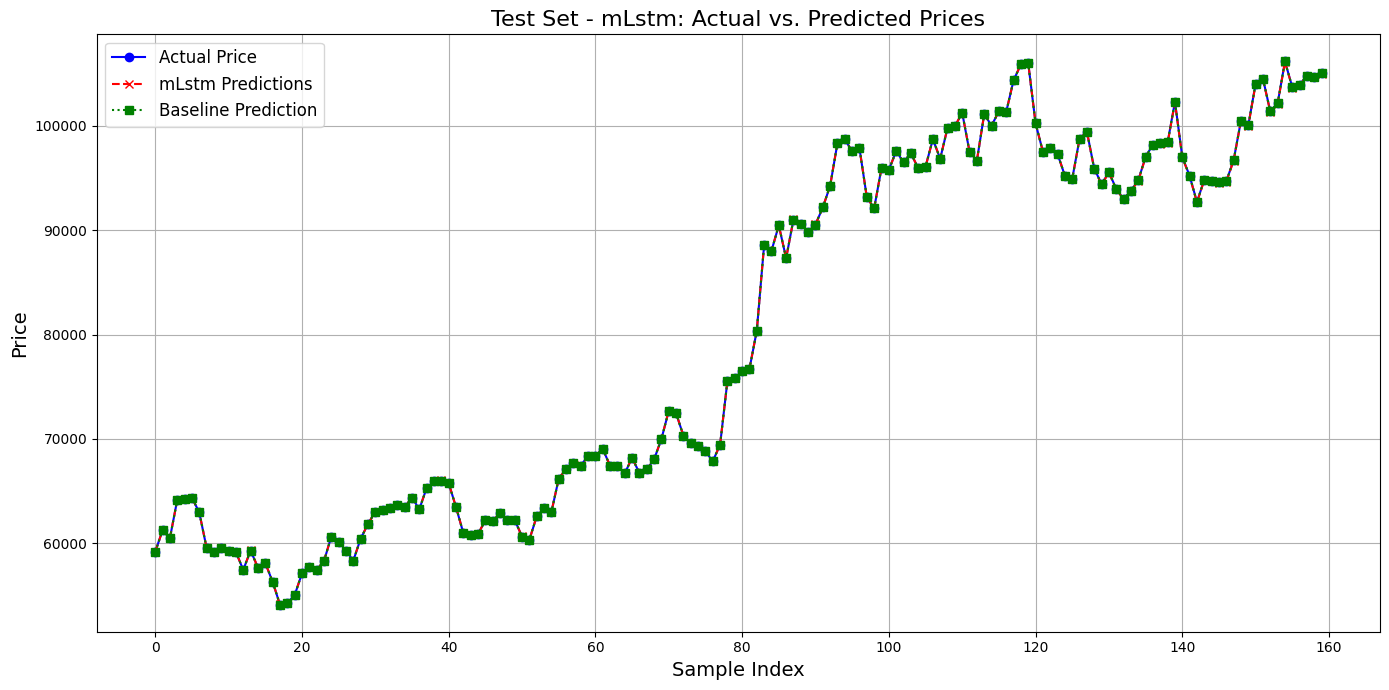

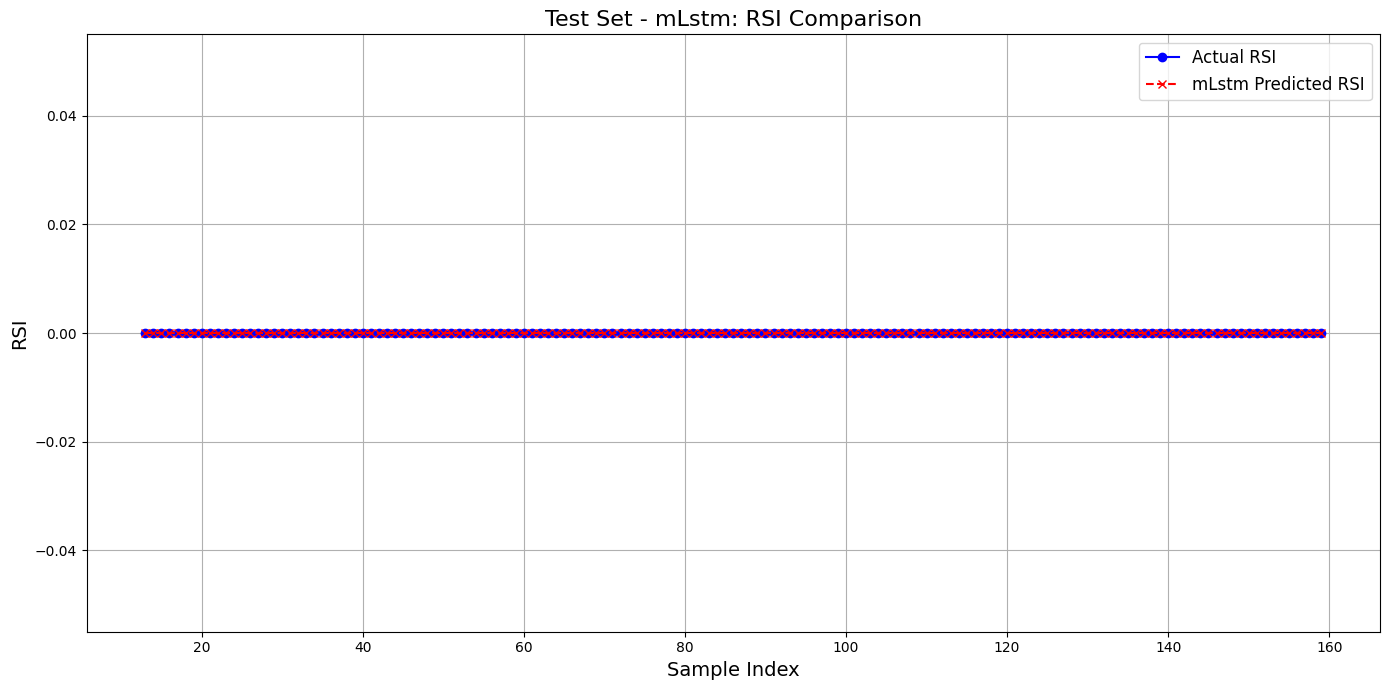

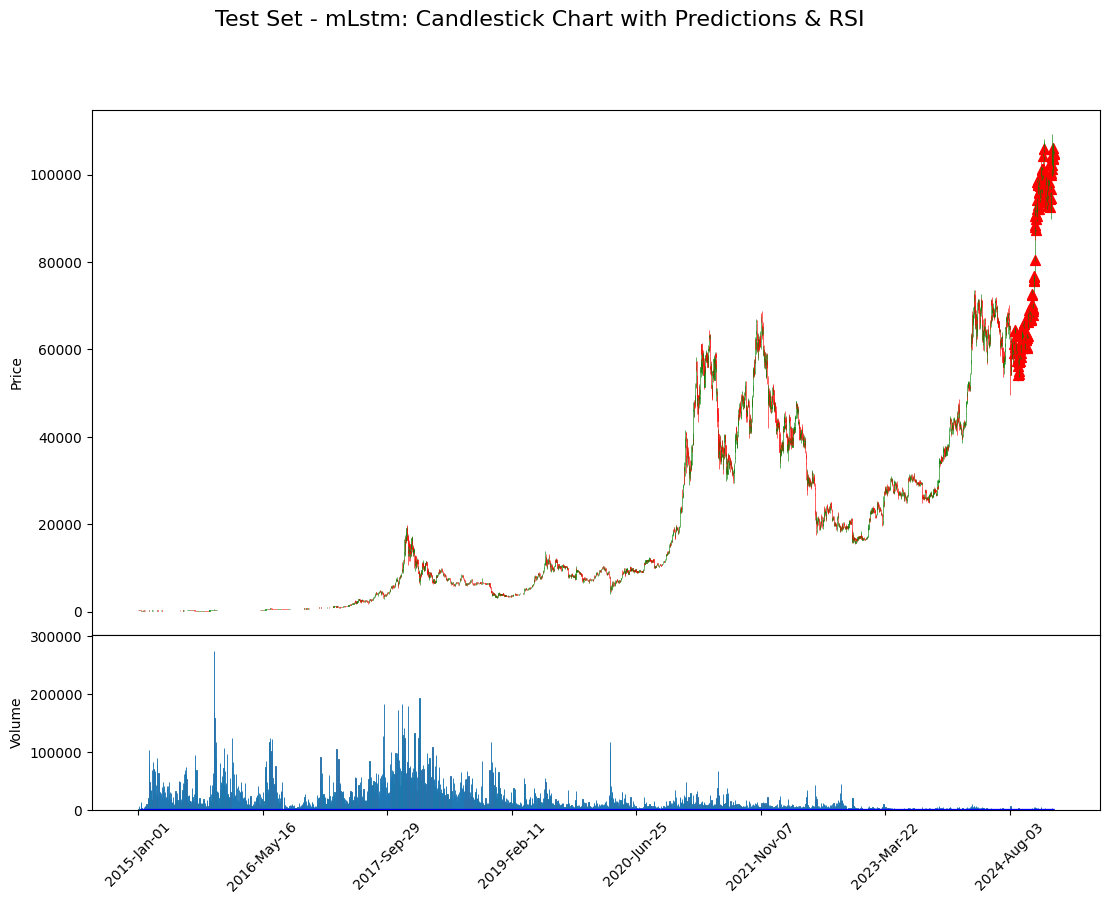

Test candlestick chart saved to 'result_history/BTC_USD_24_0_candlestick.png'

Evaluation completed for 'BTC_USD' with model 'mLstm' and forecast_history=24.
Metrics and plots appended to 'result_history/BTC_USD_metrics.txt' and saved in 'result_history'


In [ ]:
# Plot: Actual vs. Predicted Prices (Test Set)
try:
    indices = np.arange(len(actuals))
    plt.figure(figsize=(14, 7))
    plt.plot(indices, actuals, label='Actual Price', marker='o', linestyle='-', color='blue')
    plt.plot(indices, test_predictions, label=f"{model_name} Predictions", marker='x', linestyle='--', color='red')
    if include_baseline:
        plt.plot(indices, baseline_predictions, label='Baseline Prediction', marker='s', linestyle=':', color='green')
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.title(f"Test Set - {model_name}: Actual vs. Predicted Prices", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    price_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_test_price_plot.png"
    price_plot_path = result_history_dir / price_plot_filename
    plt.savefig(price_plot_path)
    plot.show()
    plt.close()
    log_print(f"Test price plot saved to '{price_plot_path}'")
except Exception as e:
    log_print(f"Error during test price plotting: {e}")

# Plot: RSI Comparison (Test Set)
try:
    indices = np.arange(len(actuals))
    plt.figure(figsize=(14, 7))
    rsi_actual = compute_rsi(actuals, period=14)
    rsi_pred = compute_rsi(test_predictions, period=14)
    plt.plot(indices, rsi_actual, label='Actual RSI', marker='o', linestyle='-', color='blue')
    plt.plot(indices, rsi_pred, label=f"{model_name} Predicted RSI", marker='x', linestyle='--', color='red')
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('RSI', fontsize=14)
    plt.title(f"Test Set - {model_name}: RSI Comparison", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    rsi_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_test_rsi_plot.png"
    rsi_plot_path = result_history_dir / rsi_plot_filename
    plt.savefig(rsi_plot_path)
    plot.show()
    plt.close()
    log_print(f"Test RSI comparison plot saved to '{rsi_plot_path}'")
except Exception as e:
    log_print(f"Error during test RSI plotting: {e}")

# Test Candlestick Chart with Predictions & RSI
try:
    df_candle = df_raw.copy()
    df_candle[datetime_col] = pd.to_datetime(df_candle[datetime_col])
    df_candle = df_candle.sort_values(by=datetime_col)
    if 'Price' in df_candle.columns:
        df_candle.rename(columns={'Price': 'Close'}, inplace=True)
    if 'Vol.' in df_candle.columns:
        df_candle.rename(columns={'Vol.': 'Volume'}, inplace=True)
        df_candle['Volume'] = df_candle['Volume'].apply(
            lambda x: float(x.replace('K', '')) * 1000 if isinstance(x, str) and 'K' in x else float(x)
        )
    df_candle.set_index(datetime_col, inplace=True)
    rsi_values = compute_rsi(df_candle['Close'].values, period=14)
    df_candle['RSI'] = rsi_values
    # Use the Date column from test_df as the index for predictions
    test_index = pd.to_datetime(test_df[datetime_col])
    n_missing = forecast_history + forecast_horizon - 1
    pred_full = [np.nan] * n_missing + list(test_predictions.flatten())
    pred_full = pred_full[:len(test_index)]
    pred_series = pd.Series(pred_full, index=test_index)
    df_candle.loc[test_index, 'Predicted'] = pred_series
    apds = [
        mpf.make_addplot(df_candle['RSI'], panel=1, color='blue', ylabel='RSI'),
        mpf.make_addplot(df_candle['Predicted'], type='scatter', markersize=50, marker='^', color='red', panel=0)
    ]
    mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
    style = mpf.make_mpf_style(marketcolors=mc)
    volume_flag = True if 'Volume' in df_candle.columns else False
    fig, axlist = mpf.plot(df_candle, type='candle', style=style, volume=volume_flag,
                            addplot=apds, returnfig=True, figsize=(14, 10), panel_ratios=(3, 1))
    fig.suptitle(f"Test Set - {model_name}: Candlestick Chart with Predictions & RSI", fontsize=16)
    candle_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_candlestick.png"
    candle_plot_path = result_history_dir / candle_plot_filename
    fig.savefig(candle_plot_path)
    plt.show()
    plt.close(fig)
    log_print(f"Test candlestick chart saved to '{candle_plot_path}'")
except Exception as e:
    log_print(f"Error during test candlestick plotting: {e}")

log_print(f"\nEvaluation completed for '{csv_base}' with model '{model_name}' and forecast_history={forecast_history}.")
log_print(f"Metrics and plots appended to '{metrics_path}' and saved in '{result_history_dir}'")